#### **Assignment-3 Reinforcement learning programming**
Submitted by : Nikhil Shankar Chirakkal Sivasankaran
9026254

## Setup and Dependencies

In [40]:
import os
import random
import matplotlib.pyplot as plt
from collections import deque
from IPython import display
import gym

# For dependencies installation - with specific versions to avoid conflicts
!pip install numpy==1.26.0 # Use compatible numpy version
!pip install tensorflow
!pip install gym  # Using older gym version instead of gymnasium
!pip install gym[atari]
!pip install opencv-python
!pip install autorom
!pip install autorom[accept-rom-license]

import numpy as np
import gym  # Using older gym instead of gymnasium
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

##### **Utils File**

In [41]:
import numpy as np

# This is specific to the pong environment
def img_crop(img):
    return img[30:-12,:,:]

# GENERAL Atari preprocessing steps
def downsample(img):
    # We will take only half of the image resolution
    return img[::2, ::2]

def transform_reward(reward):
    return np.sign(reward)

def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

# Normalize grayscale image from -1 to 1.
def normalize_grayscale(img):
    return (img - 128) / 128 - 1

def process_frame(img, image_shape):
    img = img_crop(img)
    img = downsample(img)    # Crop and downsize (by 2)
    img = to_grayscale(img)       # Convert to greyscale by averaging the RGB values
    img = normalize_grayscale(img)  # Normalize from -1 to 1.

    return np.expand_dims(img.reshape(image_shape[0], image_shape[1], 1), axis=0)

#### **Environment Hyperparameters**

In [42]:
ENV_NAME = 'PongDeterministic-v4'
print("Using environment:", ENV_NAME)

# Image processing parameters
IMAGE_SHAPE = (84, 80)  # Standard image size for Atari games
STACK_SIZE = 4          # Number of frames to stack to capture motion

# Hyperparameters as specified in the assignment
# Update these hyperparameters
BATCH_SIZE = 8            # Increase from 8 to at least 32
TARGET_UPDATE_FREQ = 1000    # Update based on frames, not episodes
GAMMA = 0.99                 # Increase discount factor
EPSILON_DECAY = 0.995       # Much slower decay
TRAINING_START = 10000       # Start training after collecting more experiences
LEARNING_RATE = 0.00025      # Slightly higher learning rate         # Minimum exploration rate ε_min
EPSILON_INIT = 1.0           # Initial exploration rate ε
EPSILON_DECAY = 0.9995       # Much slower decay rate
EPSILON_MIN = 0.05           # Minimum exploration rate ε_min
# Additional hyperparameters (not explicitly specified in assignment)
MEMORY_SIZE = 10000         # Replay buffer size
TRAINING_START = 1000       # Start training after collecting this many frames


Using environment: PongDeterministic-v4


#### **Experience Replay Buffer**
(state, action, reward, next_state, done)


In [43]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to the buffer"""
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Randomly sample a batch of experiences from the buffer"""
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*samples))
        return states, actions, rewards, next_states, dones

    def size(self):
        """Return the current size of the buffer"""
        return len(self.buffer)

#### **Deep Q-Network Architecture**
Input : Convolutional layers
Output : Q-Values

In [44]:
def build_dqn(input_shape, n_actions):
    model = Sequential([
        # Convolutional layers to process the game frames
        Conv2D(32, 8, strides=4, activation='relu', input_shape=input_shape),
        Conv2D(64, 4, strides=2, activation='relu'),
        Conv2D(64, 3, strides=1, activation='relu'),
        Flatten(),
        # Fully connected layers for Q-value prediction
        Dense(512, activation='relu'),
        Dense(n_actions, activation='linear')  # Linear activation for Q-values
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse')
    return model

#### **DQN-Agent**

In [45]:
class DQNAgent:
    def __init__(self, state_shape, n_actions):
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.epsilon = EPSILON_INIT

        # Create main and target networks
        self.model = build_dqn(state_shape, n_actions)        # Online network
        self.target_model = build_dqn(state_shape, n_actions) # Target network
        self.update_target()  # Initialize target network

        # Initialize replay buffer
        self.memory = ReplayBuffer(MEMORY_SIZE)

        # Initialize trackers
        self.frame_count = 0
        self.episode_count = 0

    def update_target(self):
        """Copy weights from the online network to the target network"""
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        """Select an action using an epsilon-greedy policy"""
        # Exploration: random action
        if np.random.rand() < self.epsilon:
            return random.randrange(self.n_actions)

        # Exploitation: best action according to Q-values
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    # def train(self):
    #   """Train the agent using a random batch from the replay buffer"""
    #   # Update epsilon based on frames, not per batch
    #   if self.frame_count % 4 == 0 and self.epsilon > EPSILON_MIN:  # Update every 4 frames
    #       self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

    #   self.frame_count += 1
    #   if self.memory.size() < TRAINING_START:
    #       return 0  # Not enough samples for training

    #   # Sample a random batch from the replay buffer
    #   states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)

    #   # Reshape states and next_states to remove the extra dimension
    #   states = states.reshape(BATCH_SIZE, self.state_shape[0], self.state_shape[1], self.state_shape[2])
    #   next_states = next_states.reshape(BATCH_SIZE, self.state_shape[0], self.state_shape[1], self.state_shape[2])

    #   # Calculate target Q-values using the target network
    #   next_q_values = self.target_model.predict(next_states, verbose=0)
    #   max_next_q = np.max(next_q_values, axis=1)

    #   # Calculate the TD target: r + γ * max_a Q'(s', a)
    #   targets = rewards + (1 - dones) * GAMMA * max_next_q

    #   # Update Q-values only for the actions that were taken
    #   current_q = self.model.predict(states, verbose=0)
    #   batch_indices = np.arange(BATCH_SIZE)
    #   current_q[batch_indices, actions] = targets

    #   # Train the online network
    #   loss = self.model.train_on_batch(states, current_q)

    #   # Update epsilon according to the decay schedule
    #   if self.epsilon > EPSILON_MIN:
    #       self.epsilon *= EPSILON_DECAY

    #   return loss

    def train(self):
      """Train the agent using a random batch from the replay buffer"""
      if self.memory.size() < TRAINING_START:
          self.frame_count += 1
          return 0  # Not enough samples for training

      # Sample a random batch from the replay buffer
      states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)

      # Reshape states and next_states to remove the extra dimension
      states = states.reshape(BATCH_SIZE, self.state_shape[0], self.state_shape[1], self.state_shape[2])
      next_states = next_states.reshape(BATCH_SIZE, self.state_shape[0], self.state_shape[1], self.state_shape[2])

      # Calculate target Q-values using the target network
      next_q_values = self.target_model.predict(next_states, verbose=0)

      # Use Double DQN approach to reduce overestimation
      next_actions = np.argmax(self.model.predict(next_states, verbose=0), axis=1)
      max_next_q = next_q_values[np.arange(BATCH_SIZE), next_actions]

      # Calculate the TD target: r + γ * max_a Q'(s', a)
      targets = rewards + (1 - dones) * GAMMA * max_next_q

      # Update Q-values only for the actions that were taken
      current_q = self.model.predict(states, verbose=0)
      batch_indices = np.arange(BATCH_SIZE)
      current_q[batch_indices, actions] = targets

      # Train the online network
      loss = self.model.train_on_batch(states, current_q)

      # Update epsilon according to the frame-based decay schedule
      if self.frame_count % 4 == 0 and self.epsilon > EPSILON_MIN:  # Update every 4 frames
          self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

      # Check if it's time to update the target network
      if self.frame_count % TARGET_UPDATE_FREQ == 0:
          self.update_target()
          print(f"Updated target network at frame {self.frame_count}")

      self.frame_count += 1
      return loss

    def store_transition(self, state, action, reward, next_state, done):
        """Store a transition in the replay buffer"""
        self.memory.add(state, action, reward, next_state, done)

    def save_model(self, filepath):
        """Save the trained model to disk"""
        self.model.save(filepath)

    def load_model(self, filepath):
        """Load a pre-trained model from disk"""
        self.model = tf.keras.models.load_model(filepath)
        self.update_target()

#### **Frame Processing**
- To reduce processing time we combine multiple frames.

In [46]:
class FrameStacker:
    def __init__(self, image_shape, stack_size):
        self.image_shape = image_shape
        self.stack_size = stack_size
        # Initialize frame buffer with zeros
        self.frames = np.zeros((1, image_shape[0], image_shape[1], stack_size))

    def reset(self, frame):
        """Reset the frame stack with an initial frame"""
        processed_frame = process_frame(frame, self.image_shape)
        # Fill all stack positions with the initial frame
        for i in range(self.stack_size):
            self.frames[0, :, :, i] = processed_frame[0, :, :, 0]
        return self.frames

    def add_frame(self, frame):
        """Process a new frame and add it to the stack"""
        processed_frame = process_frame(frame, self.image_shape)
        # Move frames to the left and add new frame to the right
        self.frames[0, :, :, :-1] = self.frames[0, :, :, 1:]
        self.frames[0, :, :, -1] = processed_frame[0, :, :, 0]
        # Remove the extra dimension here before returning
        #return self.frames.squeeze(axis=1) # This line is removed
        return self.frames # Instead, return self.frames directly


#### **Model Training**

In [47]:
def train_dqn(env_name, total_episodes=20, render=True, type="batch_8"):
    # First, mount Google Drive if not already mounted
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Create a directory for models if it doesn't exist
    import os
    save_path = '/content/drive/MyDrive/pong_dqn_models_' + type
    os.makedirs(save_path, exist_ok=True)

    # Create environment (old gym API doesn't use render_mode parameter)
    env = gym.make(env_name, render_mode='rgb_array')
    n_actions = env.action_space.n

    # Print some environment info
    print(f"Environment: {env_name}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Action Space: {env.action_space}")

    # Initialize the agent
    agent = DQNAgent((IMAGE_SHAPE[0], IMAGE_SHAPE[1], STACK_SIZE), n_actions)

    # Metrics to track progress
    episode_rewards = []
    episode_losses = []

    # Import numpy here, inside the function's scope
    import numpy as np

    for episode in range(total_episodes):
        # Reset environment and get initial state (old gym API)
        observation, _ = env.reset()
        frame_stacker = FrameStacker(IMAGE_SHAPE, STACK_SIZE)
        state = frame_stacker.reset(observation)

        episode_reward = 0
        episode_loss = []
        done = False
        step = 0

        # Run one episode
        while not done:
            # Select action using epsilon-greedy policy
            action = agent.get_action(state)

            # Execute action in the environment
            next_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Process reward (clip to -1, 0, 1 as per standard DQN implementation)
            processed_reward = transform_reward(reward)

            # Stack frames for next state
            next_state = frame_stacker.add_frame(next_observation)

            # Store transition in replay buffer
            agent.store_transition(state, action, processed_reward, next_state, done)

            # Train agent
            loss = agent.train()
            if loss != 0:
                episode_loss.append(loss)

            # Update state and accumulate reward
            state = next_state
            episode_reward += reward
            step += 1

            # Render if required (every 10 episodes to avoid slowing down training)
            if render and episode % 10 == 0:
                display.clear_output(wait=True)
                plt.imshow(env.render())
                plt.axis('off')
                display.display(plt.gcf())
                plt.clf()

        # Update target network according to update frequency
        agent.episode_count += 1
        if agent.episode_count % TARGET_UPDATE_FREQ == 0:
            agent.update_target()
            print(f"Updated target network at episode {agent.episode_count}")

        # Record metrics
        episode_rewards.append(episode_reward)
        if episode_loss:
            episode_losses.append(np.mean(episode_loss))
        else:
            episode_losses.append(0)

        # Print progress
        print(f"Episode {episode+1}/{total_episodes}, Steps: {step}, Reward: {episode_reward}, Epsilon: {agent.epsilon:.4f}")

        # Save model every 3 episodes to Google Drive
        if (episode + 1) % 5 == 0:
            model_path = os.path.join(save_path, f"pong_dqn_episode_{episode+1}.keras")
            agent.save_model(model_path)
            print(f"Model saved at episode {episode+1} to {model_path}")

    # Save final model to Google Drive
    final_model_path = os.path.join(save_path, "pong_dqn_final.keras")
    agent.save_model(final_model_path)
    print(f"Final model saved to {final_model_path}!")

    # Also save the training metrics to Google Drive
    import numpy as np
    metrics_path = os.path.join(save_path, "training_metrics.npz")
    np.savez(metrics_path, rewards=episode_rewards, losses=episode_losses)
    print(f"Training metrics saved to {metrics_path}")

    env.close()

    return episode_rewards, episode_losses

#### **Plot Training Batch Size - 8**
##### Updated every thousand frames


Mounted at /content/drive
Environment: PongDeterministic-v4
Observation Space: Box(0, 255, (210, 160, 3), uint8)
Action Space: Discrete(6)
Episode 1/10, Steps: 881, Reward: -21.0, Epsilon: 1.0000
Updated target network at frame 1000
Episode 2/10, Steps: 850, Reward: -21.0, Epsilon: 0.9125
Updated target network at frame 2000
Episode 3/10, Steps: 811, Reward: -21.0, Epsilon: 0.8244
Updated target network at frame 3000
Episode 4/10, Steps: 792, Reward: -21.0, Epsilon: 0.7467
Updated target network at frame 4000
Episode 5/10, Steps: 948, Reward: -19.0, Epsilon: 0.6633
Model saved at episode 5 to /content/drive/MyDrive/pong_dqn_models_batch_8/pong_dqn_episode_5.keras
Updated target network at frame 5000
Episode 6/10, Steps: 947, Reward: -20.0, Epsilon: 0.5891
Updated target network at frame 6000
Episode 7/10, Steps: 876, Reward: -21.0, Epsilon: 0.5280
Episode 8/10, Steps: 792, Reward: -21.0, Epsilon: 0.4782
Updated target network at frame 7000
Episode 9/10, Steps: 811, Reward: -21.0, Epsil

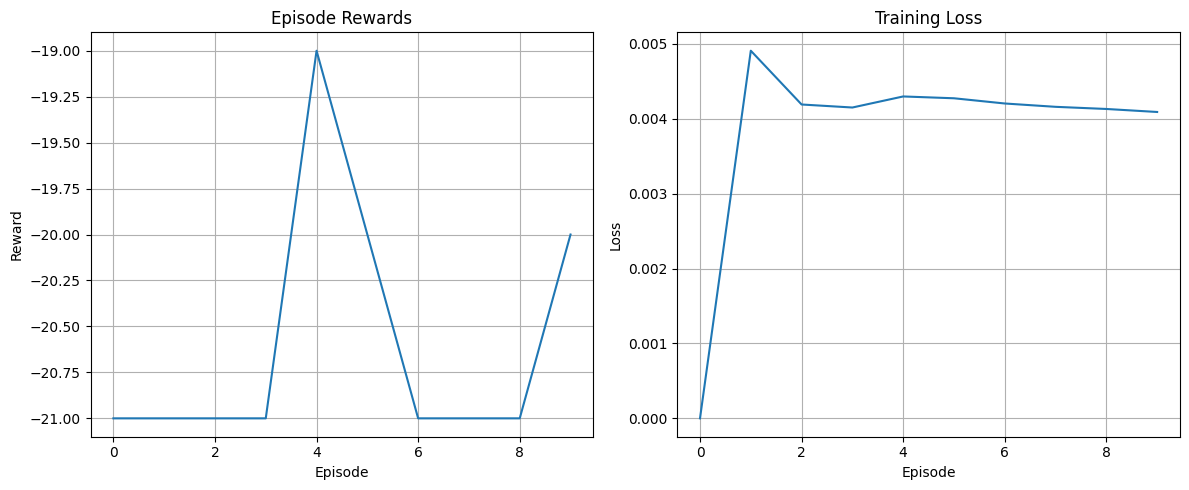

In [48]:
rewards, losses = train_dqn(ENV_NAME, total_episodes=10, render=False, type="batch_8")

## Visualize Training Results
"""
This code visualizes the training progress by plotting the rewards and losses.
"""
# Plot the rewards
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)

# Adding a moving average to see trends better
if len(rewards) > 10:
    moving_avg = np.convolve(rewards, np.ones(10)/10, mode='valid')
    plt.plot(range(9, len(rewards)), moving_avg, 'r', label='10-episode moving average')
    plt.legend()

# Plot the losses
plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_results.png')  # Save the figure
plt.show()

#### **Evaluation**

In [54]:
import gym

def evaluate_agent(env_name, model_filename, n_episodes=5, render=True, type="batch_8"):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)  # Don't force remount if already mounted

    # Construct path to the model file
    model_path = f'/content/drive/MyDrive/pong_dqn_models_{type}/{model_filename}'
    print(f"Loading model from: {model_path}")
    """Evaluate a trained DQN agent."""
    env = gym.make(env_name, render_mode='rgb_array')
    n_actions = env.action_space.n

    # Load the agent
    agent = DQNAgent((IMAGE_SHAPE[0], IMAGE_SHAPE[1], STACK_SIZE), n_actions)
    agent.load_model(model_path)
    # Use a small epsilon for some exploration during evaluation
    agent.epsilon = 0.05

    total_rewards = []

    for episode in range(n_episodes):
        observation, _ = env.reset()
        frame_stacker = FrameStacker(IMAGE_SHAPE, STACK_SIZE)
        state = frame_stacker.reset(observation)

        episode_reward = 0
        done = False
        step = 0

        while not done:
            # Select action
            action = agent.get_action(state)

            # Execute action
            next_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Stack frames for next state
            next_state = frame_stacker.add_frame(next_observation)

            # Update state and accumulate reward
            state = next_state
            episode_reward += reward
            step += 1

            # Render if required
            if render:
                display.clear_output(wait=True)
                plt.imshow(env.render())
                plt.axis('off')
                display.display(plt.gcf())
                plt.clf()

        total_rewards.append(episode_reward)
        print(f"Evaluation Episode {episode+1}/{n_episodes}, Steps: {step}, Reward: {episode_reward}")

    # Calculate statistics
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)

    print(f"Evaluation Results:")
    print(f"Average Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Min Reward: {np.min(total_rewards)}")
    print(f"Max Reward: {np.max(total_rewards)}")

    env.close()
    return total_rewards

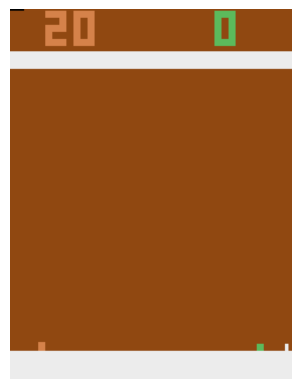

Evaluation Episode 5/5, Steps: 764, Reward: -21.0
Evaluation Results:
Average Reward: -20.80 ± 0.40
Min Reward: -21.0
Max Reward: -20.0
Average Evaluation Reward: -20.8


<Figure size 640x480 with 0 Axes>

In [55]:

# To evaluate the trained agent, uncomment and run this cell after training
evaluation_rewards = evaluate_agent(ENV_NAME, "pong_dqn_final.keras", n_episodes=5, type="batch_8")
print(f"Average Evaluation Reward: {np.mean(evaluation_rewards)}")